In [25]:
import numpy as np
from smt.surrogate_models import KRG, RBF
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV


In [2]:
def read_data(type, folder, length):
    df = pd.DataFrame()
    parameters = pd.read_csv('Simulation_'+type+'/parameters_v1.txt')
    for i in range(length):
        new_data = pd.read_csv('Simulation_'+type+'/'+folder+'/'+type+'_X_data.csv/'+type+'_'+str(i+1)+'_data.csv')
        mean_force = new_data['FKN'].mean()
        max_force = new_data['FKN'].max()
        new_data_df = pd.DataFrame()
        new_data_df['mean_force'] = [mean_force]
        new_data_df['max_force'] = [max_force]
        for parameter in parameters.columns:
            new_data_df[parameter] = parameters[parameter][i]
        df = pd.concat([df, new_data_df])
    df = df.drop(columns=['sample'])
    df.reset_index(drop=True, inplace=True)

    return df

df = read_data(type='BENDING', folder='CONSTANT_THICKNESS_100', length=100)
df.head()

,mean_force,max_force,outer_wall_thickness,inside_wall_side_thickness,inside_wall_middle_thickness,height,width,sigma0,youngs
0,23.835890,28.542961,2.50,2.15,1.63,75.95,127.83,263.44,66771.2
1,25.324615,30.559906,2.83,2.02,1.44,75.76,127.25,246.66,69501.7
2,25.165036,29.325711,2.85,1.78,1.44,76.51,127.53,243.62,65759.5
3,24.157056,28.547982,2.71,1.72,1.51,75.41,127.61,258.13,65259.4
4,24.802531,28.899586,2.67,1.74,1.65,76.22,128.53,261.38,65053.8


In [3]:
X = df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
#Y = df[['max_force', 'mean_force']]
Y = df[['max_force']].values

In [4]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [5]:
gamma_values = np.logspace(-4, 2, num=50)
C_values = np.logspace(-1, 4, num=50)
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']

In [6]:
'''values = []
for i in range(1000):
    gamma = np.random.choice(gamma_values)
    C = np.random.choice(C_values)
    kernel = np.random.choice(kernel_values)

    svr = SVR(kernel=kernel, C=C, gamma=gamma)
    svr.fit(X_train, Y_train)
    Y_pred = svr.predict(X_val)
    mse = mean_squared_error(Y_val, Y_pred)
    values.append([mse, gamma, C, kernel])'''

'values = []\nfor i in range(1000):\n    gamma = np.random.choice(gamma_values)\n    C = np.random.choice(C_values)\n    kernel = np.random.choice(kernel_values)\n\n    svr = SVR(kernel=kernel, C=C, gamma=gamma)\n    svr.fit(X_train, Y_train)\n    Y_pred = svr.predict(X_val)\n    mse = mean_squared_error(Y_val, Y_pred)\n    values.append([mse, gamma, C, kernel])'

In [7]:
'''values = np.array(values)
print(values[:,0].argmin())
print(values[values[:,0].argmin()])'''

'values = np.array(values)\nprint(values[:,0].argmin())\nprint(values[values[:,0].argmin()])'

In [8]:
'''space = dict()
space['C'] = np.logspace(-1, 4, num=100)
space['epsilon'] = np.logspace(-3, 2, num=100)'''

"space = dict()\nspace['C'] = np.logspace(-1, 4, num=100)\nspace['epsilon'] = np.logspace(-3, 2, num=100)"

In [9]:
'''search = RandomizedSearchCV(SVR(kernel='rbf', gamma='scale'), space, n_iter=1000, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, random_state=42)'''

"search = RandomizedSearchCV(SVR(kernel='rbf', gamma='scale'), space, n_iter=1000, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, random_state=42)"

In [10]:
'''result = search.fit(X_train, Y_train)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)'''

"result = search.fit(X_train, Y_train)\nprint('Best Score: %s' % result.best_score_)\nprint('Best Hyperparameters: %s' % result.best_params_)"

In [11]:
SVR_model = SVR(kernel='rbf', C=100, gamma= 0.1)
#SVR_model = SVR(kernel='rbf', epsilon=0.001, C=5.21)
SVR_model.fit(X_train,Y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=100, gamma=0.1)

In [12]:
'''theta0_values = np.linspace(0.001, 1000, 10)
print(theta0_values)
results = {}
for i in range(len(theta0_values)):
    KRG_model = KRG(theta0=[theta0_values[i]], corr='squar_exp')
    KRG_model.set_training_values(X_train, Y_train)
    KRG_model.train()
    Y_pred = KRG_model.predict_values(X_val)
    mse = mean_squared_error(Y_val, Y_pred)
    results[theta0_values[i]] = mse'''

"theta0_values = np.linspace(0.001, 1000, 10)\nprint(theta0_values)\nresults = {}\nfor i in range(len(theta0_values)):\n    KRG_model = KRG(theta0=[theta0_values[i]], corr='squar_exp')\n    KRG_model.set_training_values(X_train, Y_train)\n    KRG_model.train()\n    Y_pred = KRG_model.predict_values(X_val)\n    mse = mean_squared_error(Y_val, Y_pred)\n    results[theta0_values[i]] = mse"

In [13]:
'''print(results)
plt.plot(results.keys(), results.values())
print(min(results, key=results.get))'''

'print(results)\nplt.plot(results.keys(), results.values())\nprint(min(results, key=results.get))'

In [14]:
KRG_model = KRG(theta0=[1e-2], corr='squar_exp')
KRG_model.set_training_values(X_train, Y_train)
KRG_model.train()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...


   Training - done. Time (sec):  0.7877829


In [15]:
d0_values = np.linspace(10, 1000, 100)
print(d0_values)
results = {}
for i in range(len(d0_values)):
    RBF_model = RBF(d0=d0_values[i])
    RBF_model.set_training_values(X_train, Y_train)
    RBF_model.train()
    Y_pred = RBF_model.predict_values(X_val)
    mse = mean_squared_error(Y_val, Y_pred)
    results[d0_values[i]] = mse

[  10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.  120.
  130.  140.  150.  160.  170.  180.  190.  200.  210.  220.  230.  240.
  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.  350.  360.
  370.  380.  390.  400.  410.  420.  430.  440.  450.  460.  470.  480.
  490.  500.  510.  520.  530.  540.  550.  560.  570.  580.  590.  600.
  610.  620.  630.  640.  650.  660.  670.  680.  690.  700.  710.  720.
  730.  740.  750.  760.  770.  780.  790.  800.  810.  820.  830.  840.
  850.  860.  870.  880.  890.  900.  910.  920.  930.  940.  950.  960.
  970.  980.  990. 1000.]
___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing li

{10.0: 0.11727049705836748, 20.0: 0.09921243262854908, 30.0: 0.05076173642250299, 40.0: 0.04968205333345722, 50.0: 0.0604483021916586, 60.0: 0.06562231247429809, 70.0: 0.06738281804691726, 80.0: 0.0677740964904352, 90.0: 0.06754866478224376, 100.0: 0.06695924445067214, 110.0: 0.06610069642375657, 120.0: 0.06501780876857607, 130.0: 0.06375485613987672, 140.0: 0.062355921380913545, 150.0: 0.060877969151353815, 160.0: 0.05938079458685963, 170.0: 0.057923701022299844, 180.0: 0.0565585655181865, 190.0: 0.05532285121046987, 200.0: 0.054248559036855236, 210.0: 0.053349918756316374, 220.0: 0.05263246126134764, 230.0: 0.0520922841574471, 240.0: 0.05172165843141563, 250.0: 0.05150625974186655, 260.0: 0.05143348331334856, 270.0: 0.0514836601207501, 280.0: 0.051642946025696954, 290.0: 0.05189632803831111, 300.0: 0.05222909325973579, 310.0: 0.052626619332125354, 320.0: 0.0530819762259475, 330.0: 0.05358089428470458, 340.0: 0.0541151735792596, 350.0: 0.05467676309315379, 360.0: 0.05525889177420308, 

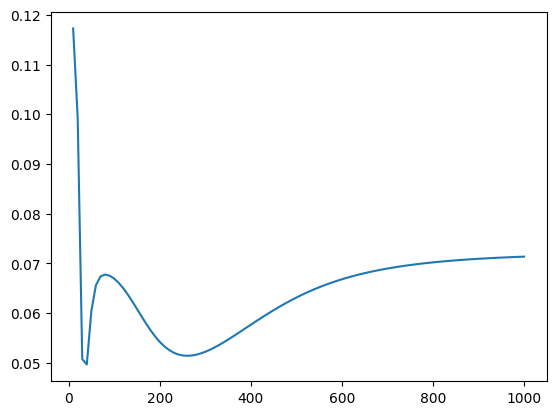

In [16]:
print(results)
plt.plot(results.keys(), results.values())
print(min(results, key=results.get))

In [17]:
RBF_model = RBF(d0=min(results, key=results.get))
#RBF_model = RBF(d0=0.1)
RBF_model.set_training_values(X_train, Y_train)
RBF_model.train()
Y_pred = RBF_model.predict_values(X_val)

___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (80 x 80 mtx) ...
         Performing LU fact. (80 x 80 mtx) - done. Time (sec):  0.0002372
      Initializing linear solver - done. Time (sec):  0.0002551
      Solving linear system (col. 0) ...
         Back solving (80 x 80 mtx) ...
         Back solving (80 x 80 mtx) - done. Time (sec):  0.0001450
      Solving linear system (col. 0) - done. Time (sec):  0.0001593
   Training - done. Time (sec):  0.0012829
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Pre

In [18]:
#   1. Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

#   2. Compile the model
model.compile(optimizer='adam', loss='mse')

#   3. Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

#    4. Train the model
history = model.fit(
    X_train,
    Y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

Epoch 1/1000
3/3 [==============================] - 0s 39ms/step - loss: 635.5072 - val_loss: 626.7587
Epoch 2/1000
3/3 [==============================] - 0s 11ms/step - loss: 631.6981 - val_loss: 622.9674
Epoch 3/1000
3/3 [==============================] - 0s 14ms/step - loss: 627.6586 - val_loss: 618.4979
Epoch 4/1000
3/3 [==============================] - 0s 11ms/step - loss: 622.8626 - val_loss: 613.0560
Epoch 5/1000
3/3 [==============================] - 0s 13ms/step - loss: 616.8981 - val_loss: 606.5774
Epoch 6/1000
3/3 [==============================] - 0s 12ms/step - loss: 609.9346 - val_loss: 598.9459
Epoch 7/1000
3/3 [==============================] - 0s 9ms/step - loss: 601.7604 - val_loss: 589.8989
Epoch 8/1000
3/3 [==============================] - 0s 9ms/step - loss: 591.8990 - val_loss: 578.9056
Epoch 9/1000
3/3 [==============================] - 0s 11ms/step - loss: 580.0363 - val_loss: 565.6343
Epoch 10/1000
3/3 [==============================] - 0s 9ms/step - loss: 56

In [19]:
Y_predicted_KRG = KRG_model.predict_values(X_val)
Y_predicted_RBF = RBF_model.predict_values(X_val)
Y_predicted_SVR = SVR_model.predict(X_val)
Y_predicted_ANN = model.predict(X_val)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Predicting - done. Time (sec):  0.0072348
   
   Prediction time/pt. (sec) :  0.0003617
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000613
   
   Prediction time/pt. (sec) :  0.0000031
   
1/1 [==============================] - 0s 61ms/step


In [20]:
mse_KRG = mean_squared_error(Y_val, Y_predicted_KRG)
mse_RBF = mean_squared_error(Y_val, Y_predicted_RBF)
mse_SVR = mean_squared_error(Y_val, Y_predicted_SVR)
mse_ANN = mean_squared_error(Y_val, Y_predicted_ANN)
print("MSE, for KRG:", mse_KRG)
print("MSE, for RBF:", mse_RBF)
print("MSE, for SVR:", mse_SVR)
print("MSE, for ANN:", mse_ANN)

MSE, for KRG: 0.1326750997543181
MSE, for RBF: 0.04968205333345722
MSE, for SVR: 0.04698602694417992
MSE, for ANN: 0.34235116729618836


In [21]:
mae_KRG = mean_absolute_error(Y_val, Y_predicted_KRG)
mae_RBF = mean_absolute_error(Y_val, Y_predicted_RBF)
mae_SVR = mean_absolute_error(Y_val, Y_predicted_SVR)
mae_ANN = mean_absolute_error(Y_val, Y_predicted_ANN)
print("MAE, for KRG:", mae_KRG)
print("MAE, for RBF:", mae_RBF)
print("MAE, for SVR:", mae_SVR)
print("MAE, for ANN:", mae_ANN)

MAE, for KRG: 0.31356948010390295
MAE, for RBF: 0.18810289881755882
MAE, for SVR: 0.17230384821000566
MAE, for ANN: 0.48475550495211567


In [44]:
mape_KRG = mean_absolute_percentage_error(Y_val, Y_predicted_KRG)
mape_RBF = mean_absolute_percentage_error(Y_val, Y_predicted_RBF)
mape_SVR = mean_absolute_percentage_error(Y_val, Y_predicted_SVR)
mape_ANN = mean_absolute_percentage_error(Y_val, Y_predicted_ANN)
print("MAPE, for KRG:", round(mape_KRG, 4)*100, "%")
print("MAPE, for RBF:", round(mape_RBF, 4)*100, "%")
print("MAPE, for SVR:", format(round(mape_SVR, 4)*100,'.2f'), "%")
print("MAPE, for ANN:", round(mape_ANN, 4)*100, "%")

MAPE, for KRG: 1.26 %
MAPE, for RBF: 0.75 %
MAPE, for SVR: 0.68 %
MAPE, for SVR: 0.6799999999999999 %
MAPE, for ANN: 1.94 %


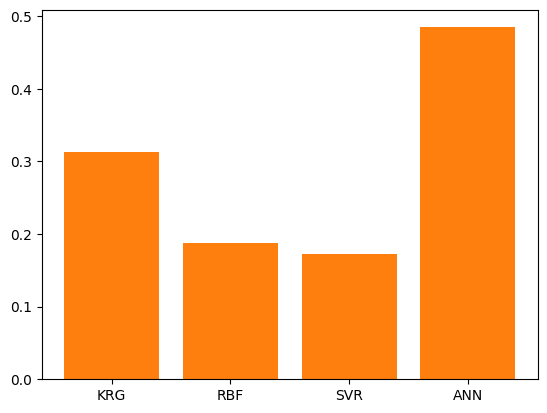

In [22]:
plt.bar(['KRG', 'RBF', 'SVR', 'ANN'], [mse_KRG, mse_RBF, mse_SVR, mse_ANN])
plt.bar(['KRG', 'RBF', 'SVR', 'ANN'], [mae_KRG, mae_RBF, mae_SVR, mae_ANN])
plt.show()

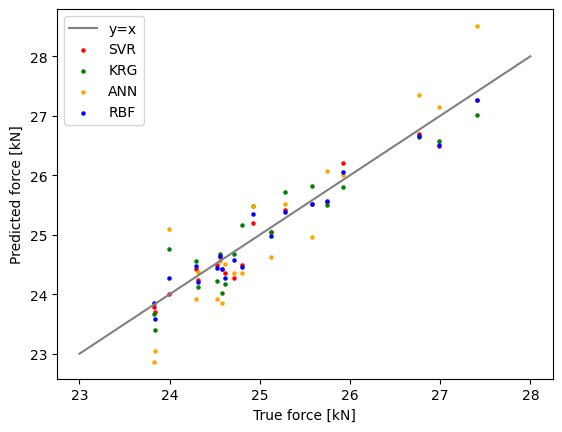

In [24]:
plt.plot([23,28], [23, 28], label='y=x', color='gray')

plt.scatter(Y_val,Y_predicted_SVR, s=5, label= 'SVR', color='red')
plt.scatter(Y_val, Y_predicted_KRG, s=5, label='KRG', color='green')
plt.scatter(Y_val, Y_predicted_ANN, s=5, label='ANN', color='orange')
plt.scatter(Y_val, Y_predicted_RBF, s=5, label='RBF', color='blue')

plt.xlabel('True force [kN]')
plt.ylabel('Predicted force [kN]')
plt.legend()